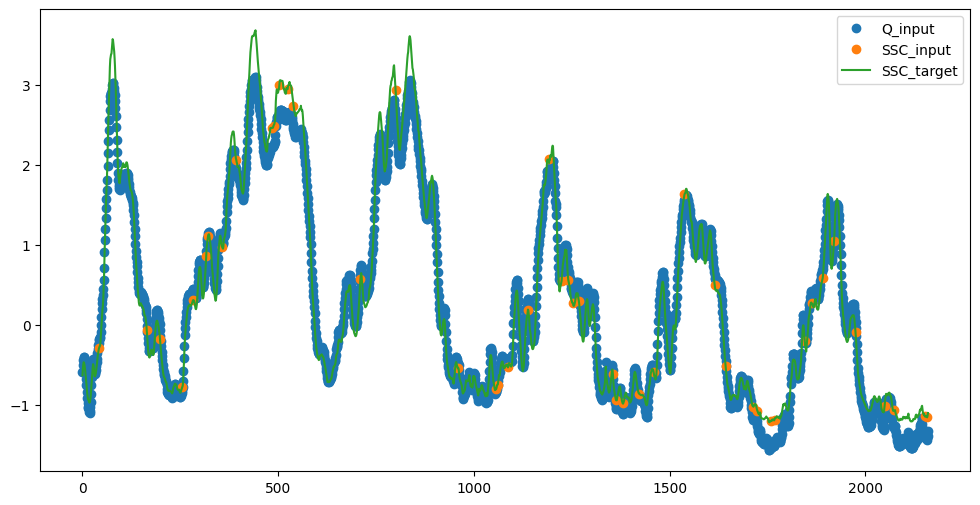

In [29]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt

from lstm import STLSTM, lr_dict_scheduler, make_step
from data import DataLoader, normalize_data

# Params
feature_labels = ['Q','SSC'] #Must be list, even for 1 value
target_label = 'SSC'
split_date = '2018-01-01'
data_drop_pct = 0.98
num_samples = 5000
sequence_length = 90
batch_size = 64
num_epochs = 30
max_grad_norm = 1
hidden_size = 16

lr_schedule = {
    0: 0.01, 
    10: 0.005, 
    30: 0.001}

feature_size = len(feature_labels)
output_size = 1

data = pd.read_parquet("../data/synthetic_daily.parquet", engine='pyarrow')

# Split the dataset into training and testing sets based on the fixed date
train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]

# Normalize the training and testing data separately
train_norm, scale = normalize_data(train_data)
test_norm, _ = normalize_data(test_data, scale=scale)

def irregular_sample(df, percent_obs, cols):
    df = df.copy() # Deep copy
    for col in cols:
        mask = np.random.rand(len(df)) < percent_obs
        df.loc[mask, col] = np.nan
    return df
    
# Split the features and targets. Drop some data from input SSC.
train_features = irregular_sample(train_norm[feature_labels],data_drop_pct,["SSC"]).values
test_features = irregular_sample(test_norm[feature_labels],data_drop_pct,["SSC"]).values
train_targets = train_norm[target_label].values
test_targets = test_norm[target_label].values

# Create batch generators 
train_dataloader_gen = DataLoader(train_features,
                                  train_targets, 
                                  batch_size, 
                                  sequence_length,
                                  train=True,
                                  split_time=True)

test_dataloader_gen = DataLoader(test_features, 
                                 test_targets, 
                                 batch_size, 
                                 sequence_length,
                                 train=False,
                                 split_time=True, 
                                 shuffle=False)

plt.figure(figsize=(12, 6))
plt.plot(test_features, label=[s+"_input" for s in feature_labels], linestyle='none',marker='o')
plt.plot(test_targets, label=target_label+"_target")
plt.legend()
plt.show()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

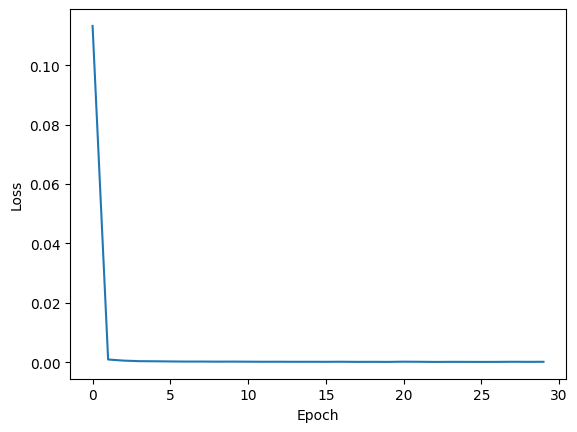

In [31]:
import jax.numpy as jnp
# Initialize the model
key = jax.random.PRNGKey(0)
model = STLSTM(in_size=feature_size,
               out_size=output_size,
               hidden_size=hidden_size,
               key=key)

# Initialize optimizer 
current_lr = lr_dict_scheduler(0, lr_schedule)
optim = optax.adam(current_lr)
opt_state = optim.init(model)

# Training loop
loss_list = []
pbar = trange(num_epochs, desc="Epoch")
for epoch in pbar:
    # Update learning rate and optimizer
    current_lr = lr_dict_scheduler(epoch, lr_schedule)
    optim = optax.adam(current_lr)
    
    total_loss = 0
    num_batches = 0
    for _, xd_batch, y_batch, dt_batch in train_dataloader_gen:
        loss, model, opt_state = make_step(model, 
                                           xd_batch, 
                                           y_batch, 
                                           opt_state, 
                                           optim, 
                                           dt=dt_batch,
                                           max_grad_norm=max_grad_norm)
        
        total_loss += loss
        num_batches += 1
        if num_batches * batch_size >= num_samples:
            break
            
    current_loss = total_loss / num_batches
    loss_list.append(current_loss)
    pbar.set_postfix_str(f"Loss: {current_loss:.4f}")


plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [32]:
# Initialize lists to store predictions and true values
predictions = []
ids = []
# Iterate over the test data
for ids_batch, xd_batch, y_batch, dt_batch in tqdm(test_dataloader_gen):
    # Make predictions for the current batch
    pred = jax.vmap(model)((xd_batch, dt_batch))
    predictions.extend(pred)
    ids.extend(ids_batch)

# # Convert lists to arrays
predictions = np.array(predictions).flatten()
ids = np.array(ids).flatten()

rescaled_pred = predictions * scale['std'][target_label] + scale['mean'][target_label]

  0%|          | 0/33 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Test Data Predictions')

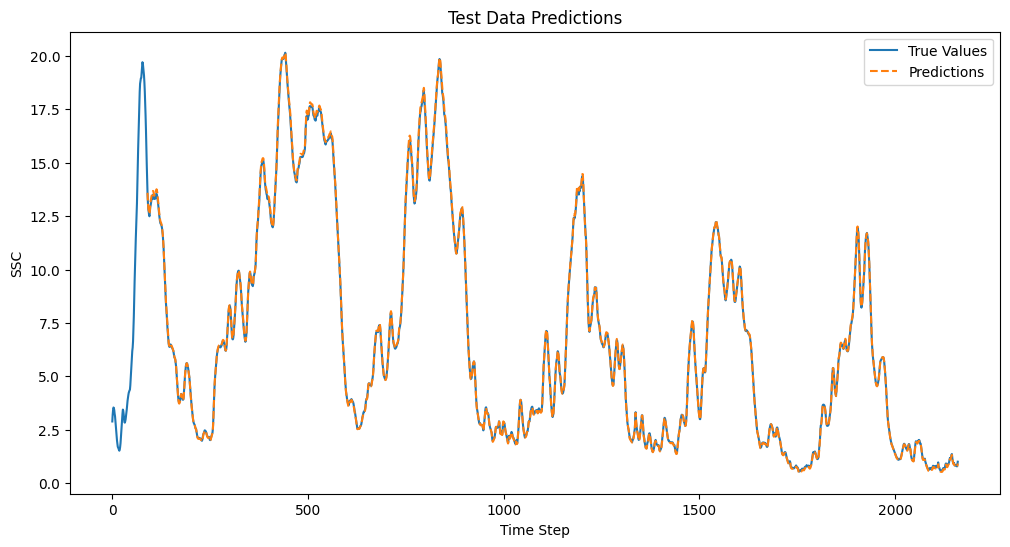

In [33]:
# Plot the true values and predictions
plt.figure(figsize=(12, 6))
# plt.plot(test_features*scale['std']['SSC']+scale['mean']['SSC'], label='Features', linestyle='none',marker='o')
test_data.reset_index()[target_label].plot(label='True Values')
plt.plot(ids, rescaled_pred, label='Predictions', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel(target_label)
plt.legend()
plt.title('Test Data Predictions')